# SciPy


<a id='index-1'></a>

## Contents

- [SciPy](#SciPy)  
  - [SciPy versus NumPy](#SciPy-versus-NumPy)  
  - [Statistics](#Statistics)  
  - [Roots and Fixed Points](#Roots-and-Fixed-Points)  
  - [Optimization](#Optimization)  
  - [Integration](#Integration)  
  - [Linear Algebra](#Linear-Algebra)  
  - [Exercises](#Exercises)  
  - [Solutions](#Solutions)  

[SciPy](http://www.scipy.org) builds on top of NumPy to provide common tools for scientific programming, such as

- [linear algebra](http://docs.scipy.org/doc/scipy/reference/linalg.html)  
- [numerical integration](http://docs.scipy.org/doc/scipy/reference/integrate.html)  
- [interpolation](http://docs.scipy.org/doc/scipy/reference/interpolate.html)  
- [optimization](http://docs.scipy.org/doc/scipy/reference/optimize.html)  
- [distributions and random number generation](http://docs.scipy.org/doc/scipy/reference/stats.html)  
- [signal processing](http://docs.scipy.org/doc/scipy/reference/signal.html)  
- etc., etc  


Like NumPy, SciPy is stable, mature and widely used

Many SciPy routines are thin wrappers around industry-standard Fortran libraries such as LAPACK, BLAS, etc.

It’s not really necessary to “learn” SciPy as a whole

A more common approach is to get some idea of what’s in the library and then look up [documentation](http://docs.scipy.org/doc/scipy/reference/index.html) as required

In this lecture we aim only to highlight some useful parts of the package

## SciPy versus NumPy

SciPy is a package that contains various tools that are built on top of NumPy, using its array data type and related functionality

In fact, when we import SciPy we also get NumPy, as can be seen from the SciPy initialization file

In [1]:
# Import numpy symbols to scipy name space
import numpy as _num
linalg = None
from numpy import *
from numpy.random import rand, randn
from numpy.fft import fft, ifft
from numpy.lib.scimath import *

__all__  = []
__all__ += _num.__all__
__all__ += ['randn', 'rand', 'fft', 'ifft']

del _num
# Remove the linalg imported from numpy so that the scipy.linalg package can be
# imported.
del linalg
__all__.remove('linalg')

However, it’s more common and better practice to use NumPy functionality explicitly

In [2]:
import numpy as np

a = np.identity(3)

What is useful in SciPy is the functionality in its subpackages

- `scipy.optimize`, `scipy.integrate`, `scipy.stats`, etc.  


These subpackages and their attributes need to be imported separately

In [3]:
from scipy.integrate import quad
from scipy.optimize import brentq
# etc

Let’s explore some of the major subpackages

## Statistics


<a id='index-4'></a>
The `scipy.stats` subpackage supplies

- numerous random variable objects (densities, cumulative distributions, random sampling, etc.)  
- some estimation procedures  
- some statistical tests  

### Random Variables and Distributions

Recall that `numpy.random` provides functions for generating random variables

In [4]:
np.random.beta(5, 5, size=3)

array([0.55779437, 0.49435792, 0.60450667])

This generates a draw from the distribution below when `a, b = 5, 5`


<a id='equation-betadist2'></a>
$$
f(x; a, b) = \frac{x^{(a - 1)} (1 - x)^{(b - 1)}}
    {\int_0^1 u^{(a - 1)} (1 - u)^{(b - 1)} du}
    \qquad (0 \leq x \leq 1) \tag{1}
$$

Sometimes we need access to the density itself, or the cdf, the quantiles, etc.

For this we can use `scipy.stats`, which provides all of this functionality as well as random number generation in a single consistent interface

Here’s an example of usage

/home/quantecon/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


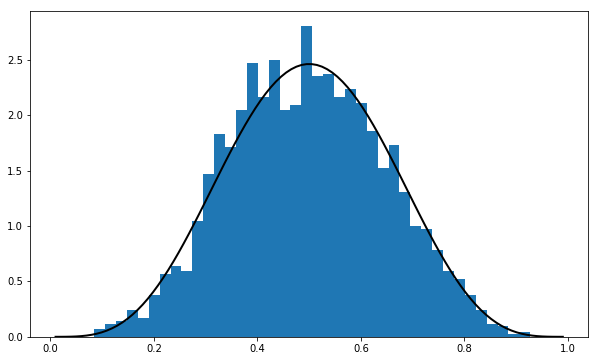

In [5]:
from scipy.stats import beta
import matplotlib.pyplot as plt
%matplotlib inline

q = beta(5, 5)      # Beta(a, b), with a = b = 5
obs = q.rvs(2000)   # 2000 observations
grid = np.linspace(0.01, 0.99, 100)

fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(obs, bins=40, normed=True)
ax.plot(grid, q.pdf(grid), 'k-', linewidth=2)
plt.show()

In this code we created a so-called `rv_frozen` object, via the call `q = beta(5, 5)`

The “frozen” part of the notation implies that `q` represents a particular distribution with a particular set of parameters

Once we’ve done so, we can then generate random numbers, evaluate the density, etc., all from this fixed distribution

In [6]:
q.cdf(0.4)      # Cumulative distribution function

0.26656768000000003

In [7]:
q.pdf(0.4)      # Density function

2.0901888000000013

In [8]:
q.ppf(0.8)      # Quantile (inverse cdf) function

0.6339134834642708

In [9]:
q.mean()

0.5

The general syntax for creating these objects is

> `identifier = scipy.stats.distribution_name(shape_parameters)`


where `distribution_name` is one of the distribution names in [scipy.stats](http://docs.scipy.org/doc/scipy/reference/stats.html)

There are also two keyword arguments, `loc` and `scale`, which following our example above, are called as

> `identifier = scipy.stats.distribution_name(shape_parameters, loc=c, scale=d)`


These transform the original random variable $ X $ into $ Y = c + d X $

The methods `rvs`, `pdf`, `cdf`, etc. are transformed accordingly

Before finishing this section, we note that there is an alternative way of calling the methods described above

For example, the previous code can be replaced by

/home/quantecon/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


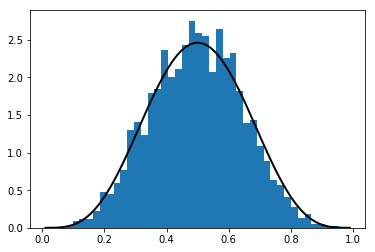

In [10]:
obs = beta.rvs(5, 5, size=2000)
grid = np.linspace(0.01, 0.99, 100)

fig, ax = plt.subplots()
ax.hist(obs, bins=40, normed=True)
ax.plot(grid, beta.pdf(grid, 5, 5), 'k-', linewidth=2)
plt.show()

### Other Goodies in scipy.stats

There are a variety statistical functions in `scipy.stats`

For example, `scipy.stats.linregress` implements simple linear regression

In [11]:
from scipy.stats import linregress

x = np.random.randn(200)
y = 2 * x + 0.1 * np.random.randn(200)
gradient, intercept, r_value, p_value, std_err = linregress(x, y)
gradient, intercept

(2.00448593904641, -0.001980032229254622)

To see the full list, consult the [documentation](http://docs.scipy.org/doc/scipy/reference/stats.html#statistical-functions)

## Roots and Fixed Points

A *root* of a real function $ f $ on $ [a,b] $ is an $ x \in [a, b] $ such that $ f(x)=0 $

For example, if we plot the function


<a id='equation-root-f'></a>
$$
f(x) = \sin(4 (x - 1/4)) + x + x^{20} - 1 \tag{2}
$$

with $ x \in [0,1] $ we get

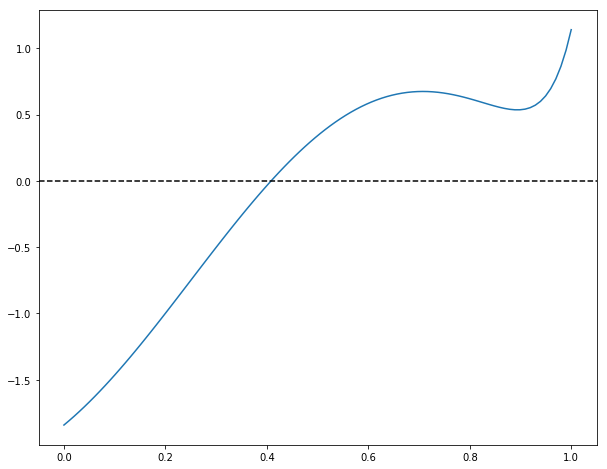

In [12]:
f = lambda x: np.sin(4 * (x - 1/4)) + x + x**20 - 1
x = np.linspace(0, 1, 100)

plt.figure(figsize=(10, 8))
plt.plot(x, f(x))
plt.axhline(ls='--', c='k')
plt.show()

The unique root is approximately 0.408

Let’s consider some numerical techniques for finding roots

### Bisection


<a id='index-6'></a>
One of the most common algorithms for numerical root finding is *bisection*

To understand the idea, recall the well known game where

- Player A thinks of a secret number between 1 and 100  
- Player B asks if it’s less than 50  
  
  - If yes, B asks if it’s less than 25  
  - If no, B asks if it’s less than 75  
  


And so on

This is bisection

Here’s a fairly simplistic implementation of the algorithm in Python

It works for all sufficiently well behaved increasing continuous functions with $ f(a) < 0 < f(b) $

In [13]:
def bisect(f, a, b, tol=10e-5):
    """
    Implements the bisection root finding algorithm, assuming that f is a
    real-valued function on [a, b] satisfying f(a) < 0 < f(b).
    """
    lower, upper = a, b

    while upper - lower > tol:
        middle = 0.5 * (upper + lower)
        # === if root is between lower and middle === #
        if f(middle) > 0:
            lower, upper = lower, middle
        # === if root is between middle and upper  === #
        else:              
            lower, upper = middle, upper

    return 0.5 * (upper + lower)

In fact SciPy provides it’s own bisection function, which we now test using the function $ f $ defined in [(2)](#equation-root-f)

In [14]:
from scipy.optimize import bisect

bisect(f, 0, 1)

0.4082935042806639

### The Newton-Raphson Method


<a id='index-8'></a>
Another very common root-finding algorithm is the [Newton-Raphson method](https://en.wikipedia.org/wiki/Newton%27s_method)

In SciPy this algorithm is implemented by `scipy.optimize.newton`

Unlike bisection, the Newton-Raphson method uses local slope information

This is a double-edged sword:

- When the function is well-behaved, the Newton-Raphson method is faster than bisection  
- When the function is less well-behaved, the Newton-Raphson might fail  


Let’s investigate this using the same function $ f $, first looking at potential instability

In [15]:
from scipy.optimize import newton

newton(f, 0.2)   # Start the search at initial condition x = 0.2

0.4082935042793568

In [16]:
newton(f, 0.7)   # Start the search at x = 0.7 instead

0.7001700000000282

The second initial condition leads to failure of convergence

On the other hand, using IPython’s `timeit` magic, we see that `newton` can be much faster

In [17]:
%timeit bisect(f, 0, 1)

69.6 µs ± 293 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [18]:
%timeit newton(f, 0.2)

18 µs ± 18.8 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


### Hybrid Methods

So far we have seen that the Newton-Raphson method is fast but not robust

This bisection algorithm is robust but relatively slow

This illustrates a general principle

- If you have specific knowledge about your function, you might be able to exploit it to generate efficiency  
- If not, then the algorithm choice involves a trade-off between speed of convergence and robustness  


In practice, most default algorithms for root finding, optimization and fixed points use *hybrid* methods

These methods typically combine a fast method with a robust method in the following manner:

1. Attempt to use a fast method  
1. Check diagnostics  
1. If diagnostics are bad, then switch to a more robust algorithm  


In `scipy.optimize`, the function `brentq` is such a hybrid method, and a good default

In [19]:
brentq(f, 0, 1)

0.40829350427936706

In [20]:
%timeit brentq(f, 0, 1)

17.8 µs ± 75.5 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


Here the correct solution is found and the speed is almost the same as `newton`

### Multivariate Root Finding


<a id='index-9'></a>
Use `scipy.optimize.fsolve`, a wrapper for a hybrid method in MINPACK

See the [documentation](http://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fsolve.html) for details

### Fixed Points


<a id='index-10'></a>
SciPy has a function for finding (scalar) fixed points too

In [21]:
from scipy.optimize import fixed_point

fixed_point(lambda x: x**2, 10.0)  # 10.0 is an initial guess

array(1.)

If you don’t get good results, you can always switch back to the `brentq` root finder, since
the fixed point of a function $ f $ is the root of $ g(x) := x - f(x) $

## Optimization


<a id='index-12'></a>
Most numerical packages provide only functions for *minimization*

Maximization can be performed by recalling that the maximizer of a function $ f $ on domain $ D $ is
the minimizer of $ -f $ on $ D $

Minimization is closely related to root finding: For smooth functions, interior optima correspond to roots of the first derivative

The speed/robustness trade-off described above is present with numerical optimization too

Unless you have some prior information you can exploit, it’s usually best to use hybrid methods

For constrained, univariate (i.e., scalar) minimization, a good hybrid option is `fminbound`

In [22]:
from scipy.optimize import fminbound

fminbound(lambda x: x**2, -1, 2)  # Search in [-1, 2]

0.0

### Multivariate Optimization


<a id='index-13'></a>
Multivariate local optimizers include `minimize`, `fmin`, `fmin_powell`, `fmin_cg`, `fmin_bfgs`, and `fmin_ncg`

Constrained multivariate local optimizers include `fmin_l_bfgs_b`, `fmin_tnc`, `fmin_cobyla`

See the [documentation](http://docs.scipy.org/doc/scipy/reference/optimize.html) for details

## Integration


<a id='index-15'></a>
Most numerical integration methods work by computing the integral of an approximating polynomial

The resulting error depends on how well the polynomial fits the integrand, which in turn depends on how “regular” the integrand is

In SciPy, the relevant module for numerical integration is `scipy.integrate`

A good default for univariate integration is `quad`

In [23]:
from scipy.integrate import quad

integral, error = quad(lambda x: x**2, 0, 1)
integral

0.33333333333333337

In fact `quad` is an interface to a very standard numerical integration routine in the Fortran library QUADPACK

It uses [Clenshaw-Curtis quadrature](https://en.wikipedia.org/wiki/Clenshaw-Curtis_quadrature),  based on expansion in terms of Chebychev polynomials

There are other options for univariate integration—a useful one is `fixed_quad`, which is fast and hence works well inside `for` loops

There are also functions for multivariate integration

See the [documentation](http://docs.scipy.org/doc/scipy/reference/integrate.html) for more details

## Linear Algebra


<a id='index-17'></a>
We saw that NumPy provides a module for linear algebra called `linalg`

SciPy also provides a module for linear algebra with the same name

The latter is not an exact superset of the former, but overall it has more functionality

We leave you to investigate the [set of available routines](http://docs.scipy.org/doc/scipy/reference/linalg.html)

## Exercises


<a id='sp-ex1'></a>

### Exercise 1

Previously we discussed the concept of [recursive function calls](https://lectures.quantecon.org/py/python_advanced_features.html#recursive-functions)

Write a recursive implementation of the bisection function described above, which we repeat here for convenience

In [24]:
def bisect(f, a, b, tol=10e-5):
    """
    Implements the bisection root finding algorithm, assuming that f is a
    real-valued function on [a, b] satisfying f(a) < 0 < f(b).
    """
    lower, upper = a, b

    while upper - lower > tol:
        middle = 0.5 * (upper + lower)
        # === if root is between lower and middle === #
        if f(middle) > 0:
            lower, upper = lower, middle
        # === if root is between middle and upper  === #
        else:              
            lower, upper = middle, upper

    return 0.5 * (upper + lower)

Test it on the function `f = lambda x: np.sin(4 * (x - 0.25)) + x + x**20 - 1` discussed above

## Solutions

### Exercise 1

Here’s a reasonable solution:

In [25]:
def bisect(f, a, b, tol=10e-5):
    """
    Implements the bisection root finding algorithm, assuming that f is a
    real-valued function on [a, b] satisfying f(a) < 0 < f(b).
    """
    lower, upper = a, b
    if upper - lower < tol:
        return 0.5 * (upper + lower)
    else:
        middle = 0.5 * (upper + lower)
        print(f'Current mid point = {middle}')
        if f(middle) > 0:   # Implies root is between lower and middle
            bisect(f, lower, middle)
        else:               # Implies root is between middle and upper
            bisect(f, middle, upper)

We can test it as follows

In [26]:
f = lambda x: np.sin(4 * (x - 0.25)) + x + x**20 - 1
bisect(f, 0, 1)

Current mid point = 0.5
Current mid point = 0.25
Current mid point = 0.375
Current mid point = 0.4375
Current mid point = 0.40625
Current mid point = 0.421875
Current mid point = 0.4140625
Current mid point = 0.41015625
Current mid point = 0.408203125
Current mid point = 0.4091796875
Current mid point = 0.40869140625
Current mid point = 0.408447265625
Current mid point = 0.4083251953125
Current mid point = 0.40826416015625
